# Notebook: Random Forest with TF-IDF and Supplemental Dataset

This notebook implements a Random Forest model using TF-IDF as well as supplemental data from the Guardian dataset. The true stories are balanced equally between the original true stories and Guardian news to avoid class imbalance. The updated code below is compatible with the latest versions of the libraries.

## Importing Libraries and Defining Constants

In [1]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Copy the helper functions file from Google Drive to local storage
!cp "drive/MyDrive/Fake/model_helperfunctions.py" .

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import model_helperfunctions
import ast
import matplotlib.pyplot as plt
import pickle
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from model_helperfunctions import identity_function

# Ensure inline plotting
%matplotlib inline

In [4]:
# Set paths and constants
DATA_PATH = "/content/drive/MyDrive/Fake/Data/"
PRE_PROCESSED_DATA_FILE_NAME = 'kaggle_newsdataset_preprocessed.csv'
GUARDIAN_DATA_FILE_NAME = 'guardian_newsdataset_cleaned.csv'
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

## Load the Data

In [5]:
df = pd.read_csv(DATA_PATH + PRE_PROCESSED_DATA_FILE_NAME,
                 low_memory=False,
                 usecols=['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [6]:
# Convert the token columns from string representation to lists
df['clean_text_tokens'] = df['clean_text_tokens'].map(ast.literal_eval)
df['clean_title_tokens'] = df['clean_title_tokens'].map(ast.literal_eval)

## Split Data by Label

In [7]:
df_fake = df[df.label == 'fake']

In [8]:
df_true_og = df[df.label == 'true']

In [9]:
# Take a random sample of the original true data to balance with fake data
df_true_og_sample = df_true_og.sample(n=len(df_fake)//2, random_state=RANDOM_STATE)

## Integrate Guardian Stories as True News

In [10]:
# For the Guardian data, load and then convert the token column
df_guard = pd.read_csv(DATA_PATH + GUARDIAN_DATA_FILE_NAME, low_memory=False)
df_guard['tt_tokens'] = df_guard['tt_tokens'].map(ast.literal_eval)

# Take a random sample from the Guardian data
df_guard_sample = df_guard.sample(n=len(df_fake)//2, random_state=RANDOM_STATE)
df_guard_sample['label'] = 'true'

In [11]:
# Combine the datasets
df_all = pd.concat([
    df_fake[['label', 'clean_text_tokens']],
    df_true_og_sample[['label', 'clean_text_tokens']],
    df_guard_sample[['label', 'tt_tokens']]
], axis=0)

# For consistency, create a unified token column named 'tt_tokens'
df_all['tt_tokens'] = df_all.apply(lambda row: row['tt_tokens'] if 'tt_tokens' in row and isinstance(row['tt_tokens'], list) else row['clean_text_tokens'] + row.get('clean_title_tokens', []), axis=1)

## Split the Data into Training and Test Sets

In [12]:
y = df_all.label
X = df_all[['tt_tokens']]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

## Encode the Labels

In [13]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Train the Model

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification report for Training set:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13957
        true       1.00      1.00      1.00     13957

    accuracy                           1.00     27914
   macro avg       1.00      1.00      1.00     27914
weighted avg       1.00      1.00      1.00     27914



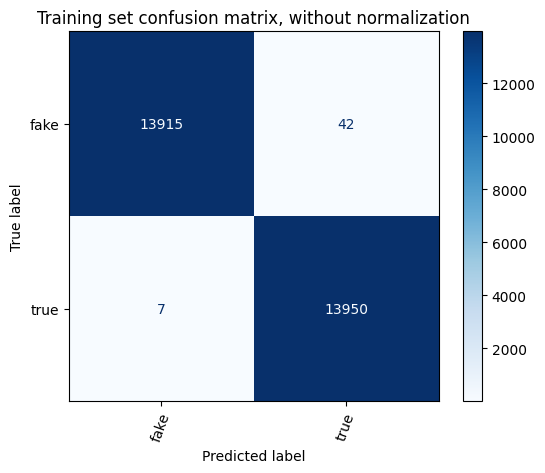

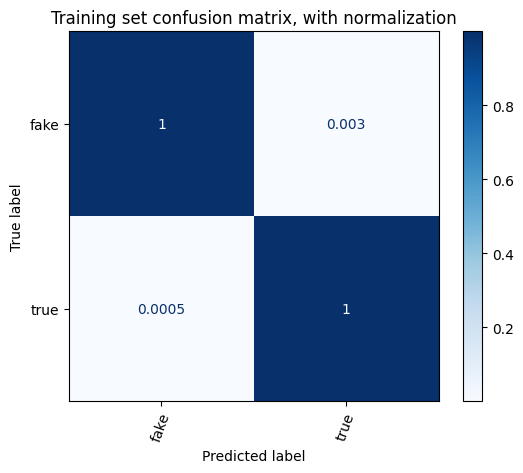

Classification report for Test set:
              precision    recall  f1-score   support

        fake       0.98      0.97      0.97      3490
        true       0.97      0.98      0.97      3489

    accuracy                           0.97      6979
   macro avg       0.97      0.97      0.97      6979
weighted avg       0.97      0.97      0.97      6979



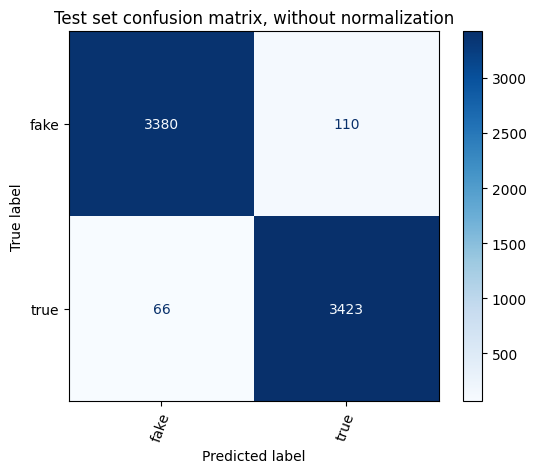

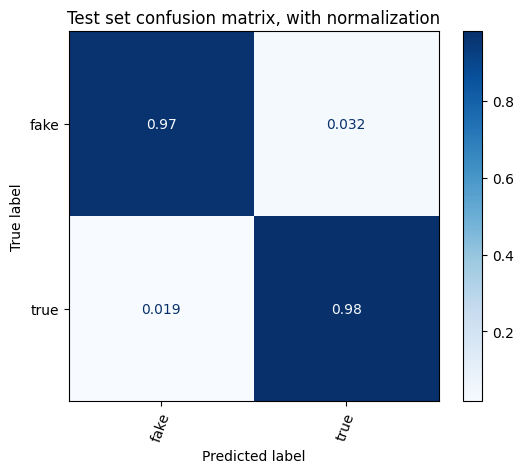

In [14]:
def train_and_eval_model(X_train_tokens, X_test_tokens, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range=(1, 1),
                        min_samples_split=2, max_depth=None):
    """
    Train and evaluate a model using a bag-of-words representation and RandomForestClassifier.
    """
    pipeline = Pipeline([
        ('bow', CountVectorizer(min_df=5,
                                preprocessor=preprocessor,
                                tokenizer=tokenizer,
                                max_df=max_df,
                                ngram_range=ngram_range)),
        ('tfidf', TfidfTransformer()),
        ('classifier', RandomForestClassifier(n_jobs=-1,
                                               random_state=RANDOM_STATE,
                                               min_samples_split=min_samples_split,
                                               max_depth=max_depth))
    ])

    pipeline.fit(X_train_tokens, y_train_enc)

    # Use the updated helper function (note the corrected name) to display reports
    model_helperfunctions.confusion_matrix_and_classification_report(pipeline,
                                                                     X_train_tokens,
                                                                     y_train_enc,
                                                                     classes_,
                                                                     'Training')

    model_helperfunctions.confusion_matrix_and_classification_report(pipeline,
                                                                     X_test_tokens,
                                                                     y_test_enc,
                                                                     classes_,
                                                                     'Test')

    return pipeline

# Train a model using only the tokenized text (tt_tokens)
pipe_expanded_sw_no_via = train_and_eval_model(
    X_train['tt_tokens'],
    X_test['tt_tokens'],
    y_train_enc,
    y_test_enc,
    le.classes_,
    preprocessor=identity_function,  # Now using the importable function
    tokenizer=model_helperfunctions.passthrough,
    min_samples_split=0.005
)

In [15]:
# Display the top 30 feature importances
feat_imp = pd.DataFrame(
    pipe_expanded_sw_no_via['classifier'].feature_importances_,
    index=pipe_expanded_sw_no_via['bow'].get_feature_names_out(),
    columns=['importance']
).sort_values('importance', ascending=False)

feat_imp.head(30)

,importance
said,0.032748
via,0.027194
!,0.016047
minister,0.015078
image,0.014762
on,0.013250
labour,0.012185
WASHINGTON,0.011591
EU,0.010651
U.S.,0.010568


## Save the Model

In [16]:
SAVE_MODEL = True
MODEL_PATH = "/content/drive/MyDrive/Models/"
MODEL_FILE_NAME = 'rf_tf-idf_plusguardian_model.sav'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

if SAVE_MODEL:
    pickle.dump(pipe_expanded_sw_no_via, open(os.path.join(MODEL_PATH, MODEL_FILE_NAME), 'wb'))
    print('Model saved successfully.')

Model saved successfully.


---### SummaryThe updated model training notebook above trains a Random Forest classifier on a balanced dataset using a bag-of-words and TF-IDF representation. The helper functions have been updated to work with recent versions of scikit-learn, and the model is saved for deployment. Note that retraining the model with the latest versions ensures compatibility with your production environment.